<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/tc_practice/blob/main/05_MHA_Transforme.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jjerry-k/tc_practice/blob/main/05_MHA_Transforme.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Multi Head Attention & Transformer

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Defining Model



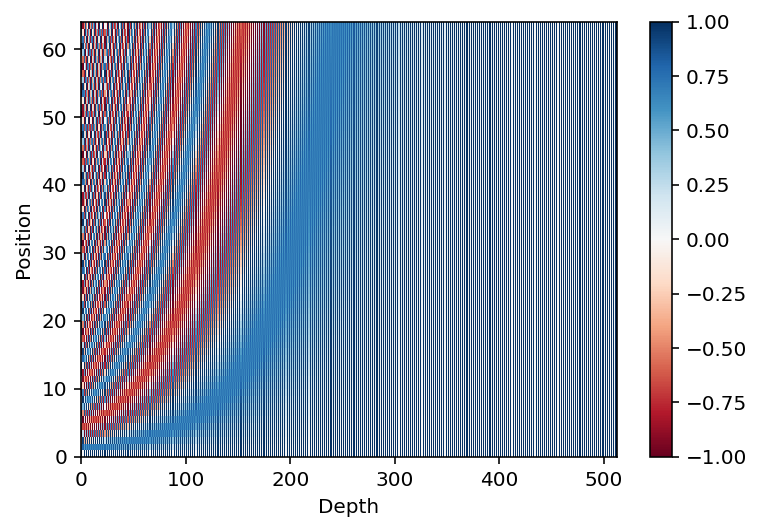

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, features):
        super(PositionalEncoding, self).__init__()
        angle_rads = self.get_angles(torch.arange(0, position).unsqueeze(-1), torch.arange(0, features).unsqueeze(0), features)
        
        angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        # (batch_size, position, features)
        self.pos_encoding = angle_rads.unsqueeze(0)

    def get_angles(self, pos, i, features):
        return pos / torch.pow(10000, (2*(i//2)) / features)
            
    def forward(self, x):
        # x: (seq_len, features)
        # pos_encoding: (position, features)
        return x + self.pos_encoding.type(x.dtype).to(x.device)[:, :x.size(1), :]

pos_encoding = PositionalEncoding(10000, 512)(torch.zeros(1, 64, 512))
plt.pcolormesh(pos_encoding[0].numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled Dot-Product Attention

$$

Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V

$$

In [3]:
class ScaledDotProductAttention(nn.Module):

    def forward(self, query, key, value, mask=None):
        dk = key.size()[-1]
        scores = query.matmul(key.transpose(-2, -1)) / np.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  
        attention = F.softmax(scores, dim=-1)
        out = attention.matmul(value)
        return out, attention

y = torch.rand(1, 60, 512)
out = ScaledDotProductAttention()(y, y, y)
out[0].shape, out[1].shape

(torch.Size([1, 60, 512]), torch.Size([1, 60, 60]))

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, features, num_heads, bias=True):
        super(MultiHeadAttention, self).__init__()
        assert features % num_heads == 0, f'"features"(features) should be divisible by "head_num"(num_heads)'
        
        self.features = features
        self.num_heads = num_heads
        self.bias = bias
        self.depth = features // num_heads

        self.wq = nn.Linear(features, features, bias=bias)
        self.wk = nn.Linear(features, features, bias=bias)
        self.wv = nn.Linear(features, features, bias=bias)

        self.fc = nn.Linear(features, features, bias=bias)

    def split_heads(self, x, batch_size):
        # batch_sie, num_heads, seq_len, depth
        x = x.reshape(batch_size, -1, self.num_heads, self.depth)
        return x.permute([0, 2, 1, 3])
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        # print(q.shape, k.shape, v.shape)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # print(q.shape, k.shape, v.shape)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v, mask)
        # print(scaled_attention.shape, attention_weights.shape)

        scaled_attention = scaled_attention.permute([0, 2, 1, 3])

        concat_attention = scaled_attention.reshape(batch_size, -1, self.features)

        out = self.fc(concat_attention)

        return out, attention_weights

temp_mha = MultiHeadAttention(features=512, num_heads=8)
out, attn = temp_mha(q=torch.rand(1, 45, 512), k=y, v=y, mask=None)
print(out.shape, attn.shape)

torch.Size([1, 45, 512]) torch.Size([1, 8, 45, 60])


In [5]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, features, fffeatures):
        super(FeedForwardNetwork, self).__init__()

        layer_list = [
            nn.Linear(features, fffeatures),
            nn.ReLU(True),
            nn.Linear(fffeatures, features)
        ]

        self.net = nn.Sequential(*layer_list)
    def forward(self, x):
        return self.net(x)

sample_ffn = FeedForwardNetwork(512, 2048)
sample_ffn(torch.rand(64, 50, 512)).shape

torch.Size([64, 50, 512])

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, features, num_heads, fffeatures, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(features, num_heads)
        self.ffn = FeedForwardNetwork(features, fffeatures)

        self.layernorm1 = nn.LayerNorm(features)
        self.layernorm2 = nn.LayerNorm(features)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    torch.rand(64, 43, 512), None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 43, 512])

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, features, num_heads, fffeatures, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(features, num_heads)
        self.mha2 = MultiHeadAttention(features, num_heads)
        self.ffn = FeedForwardNetwork(features, fffeatures)

        self.layernorm1 = nn.LayerNorm(features)
        self.layernorm2 = nn.LayerNorm(features)
        self.layernorm3 = nn.LayerNorm(features)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        # print(enc_output.shape)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    torch.rand(64, 50, 512), None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 50, 512])

In [8]:
class Encoder(nn.Module):
    def __init__(self, num_layers, features, num_heads, fffeatures, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.features = features
        self.embedding = nn.Embedding(input_vocab_size, features)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, features)

        self.enc_layers = [EncoderLayer(self.features, num_heads, fffeatures, rate) for _ in range(self.num_layers)]

        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask):
        seq_len = x.size(1)

        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        x *= torch.sqrt(torch.Tensor(self.features).to(x.device))
        # print(x.shape, self.pos_encoding.pos_encoding.shape)
        x = self.pos_encoding(x)
        # print(x.shape)
        

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i].to(x.device)(x, mask)

        return x

sample_encoder = Encoder(num_layers=2, features=512, num_heads=8, 
                         fffeatures=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000).to(device)
temp_input = torch.rand(64, 62).type(torch.LongTensor).to(device)

sample_encoder_output = sample_encoder(temp_input, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

torch.Size([64, 62, 512])


# Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, num_layers, features, num_heads, fffeatures, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.features = features
        self.embedding = nn.Embedding(target_vocab_size, features)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, features)

        self.dec_layers = [DecoderLayer(self.features, num_heads, fffeatures, rate) for _ in range(self.num_layers)]

        self.dropout = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size(1)
        attention_weights = {}

        x = self.embedding(x.long())
        x *= torch.sqrt(torch.Tensor(self.features).to(x.device))
        x = self.pos_encoding(x)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i].to(x.device)(x, enc_output, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights
    
sample_decoder = Decoder(num_layers=2, features=512, num_heads=8, 
                         fffeatures=2048, target_vocab_size=8500,
                         maximum_position_encoding=10000).to(device)
temp_input = torch.rand(64, 26).type(torch.LongTensor).to(device)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(torch.Size([64, 26, 512]), torch.Size([64, 8, 26, 62]))

# Transformer

In [10]:
class Transformer(nn.Module):
    def __init__(self, num_layers, features, num_heads, fffetures, input_vocab_size, 
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, features, num_heads, fffetures, 
                            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, features, num_heads, fffetures, 
                            target_vocab_size, pe_target, rate)

        self.final_layer = nn.Linear(features, target_vocab_size)

    def forward(self, inp, tar, enc_padding_mask, 
            look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

sample_transformer = Transformer(
    num_layers=2, features=512, num_heads=8, fffetures=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000).to(device)

temp_input = torch.rand(64, 38).type(torch.LongTensor).to(device)
temp_target = torch.rand(64, 36).type(torch.LongTensor).to(device)

fn_out, _ = sample_transformer(temp_input, temp_target, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

torch.Size([64, 36, 8000])